## Import Libraries
Let's import all necessary libraries for the analysis and along with it let's bring down our dataset

In [4]:
#Basic libraries
import pandas as pd 
import numpy as np 

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools


#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
 

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from collections import Counter

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Deep learning libraries
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

## Importing the dataset
Let's welcome our dataset and see what's inside the box

In [5]:
fake_news = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
true_news = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')
print ("The shape of the  data is (row, column):"+ str(fake_news.shape))
print (fake_news.info())
print("\n --------------------------------------- \n")
print ("The shape of the  data is (row, column):"+ str(true_news.shape))
print (true_news.info())

The shape of the  data is (row, column):(23481, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None

 --------------------------------------- 

The shape of the  data is (row, column):(21417, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


In [6]:
fake_news['output']=0
true_news['output']=1

In [7]:
fake_news['news']=fake_news['title']+fake_news['text']
fake_news=fake_news.drop(['title', 'text'], axis=1)
true_news['news']=true_news['title']+true_news['text']
true_news=true_news.drop(['title', 'text'], axis=1)
fake_news = fake_news[['subject', 'date', 'news','output']]
true_news = true_news[['subject', 'date', 'news','output']]

## Converting the date columns to datetime format
We can use pd.datetime to convert our date columns to date format we desire. But there was a problem,especially in fake_news date column. Let's check the value_counts() to see what lies inside

In [8]:
fake_news['date'].value_counts()

May 10, 2017         46
May 5, 2016          44
May 6, 2016          44
May 26, 2016         44
May 11, 2016         43
                     ..
14-Feb-18             1
Apr 2, 2015           1
November 20, 2017     1
December 11, 2017     1
December 19, 2017     1
Name: date, Length: 1681, dtype: int64

If you notice, we had links and news headline inside the date column which can give us trouble when converting to datetime format. So let's remove those records from the column 

In [9]:

fake_news=fake_news[~fake_news.date.str.contains("http")]
fake_news=fake_news[~fake_news.date.str.contains("HOST")]


Only fake news dataset had an issue with date column,Now let's proceed with converting the date column to datetime format

In [10]:
#Converting the date to datetime format
fake_news['date'] = pd.to_datetime(fake_news['date'])
true_news['date'] = pd.to_datetime(true_news['date'])

## Appending two datasets
When we are providing a dataset for the model, we have to provide it as a single file. So it's better to append both true and fake news data and preprocess it further and perform EDA

In [11]:
frames = [fake_news, true_news]
news_dataset = pd.concat(frames)
news_dataset

,subject,date,news,output
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...,...,...
21412,worldnews,2017-08-22,'Fully committed' NATO backs new U.S. approach...,1
21413,worldnews,2017-08-22,LexisNexis withdrew two products from Chinese ...,1
21414,worldnews,2017-08-22,Minsk cultural hub becomes haven from authorit...,1
21415,worldnews,2017-08-22,Vatican upbeat on possibility of Pope Francis ...,1


## Text Processing
This is an important phase for any text analysis application.There will be many unuseful content in the news which can be an obstacle when feeding to a machine learning model.Unless we remove them the machine learning model doesn't work efficiently. Lets go step by step.

## News-Punctuation Cleaning
Let's begin our text processing by removing the punctuations

In [12]:
clean_news=news_dataset.copy()

In [13]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [14]:
clean_news['news']=clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news.head()

,subject,date,news,output
0,News,2017-12-31,donald trump sends out embarrassing new year’...,0
1,News,2017-12-31,drunk bragging trump staffer started russian ...,0
2,News,2017-12-30,sheriff david clarke becomes an internet joke...,0
3,News,2017-12-29,trump is so obsessed he even has obama’s name...,0
4,News,2017-12-25,pope francis just called out donald trump dur...,0


We have removed all punctuation in our news column

## News-Stop words
A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.
We would not want these words to take up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to stop words. NLTK(Natural Language Toolkit) in python has a list of stopwords stored in 16 different languages. Source: [Geeks for Geeks](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)

For our project, we are considering the english stop words and removing those words

In [15]:
stop = stopwords.words('english')
clean_news['news'] = clean_news['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

,subject,date,news,output
0,News,2017-12-31,donald trump sends embarrassing new year’s eve...,0
1,News,2017-12-31,drunk bragging trump staffer started russian c...,0
2,News,2017-12-30,sheriff david clarke becomes internet joke thr...,0
3,News,2017-12-29,trump obsessed even obama’s name coded website...,0
4,News,2017-12-25,pope francis called donald trump christmas spe...,0


We have removed all the stop words in the review column

<a id="section-three"></a>
# Story Generation and Visualization from news
In this section we will complete do exploratory data analysis on news such as ngram analysis and understand which are all the words,context which are most likely found in fake news

## Count of news subject
Let's start by looking at the count of news types in our dataset

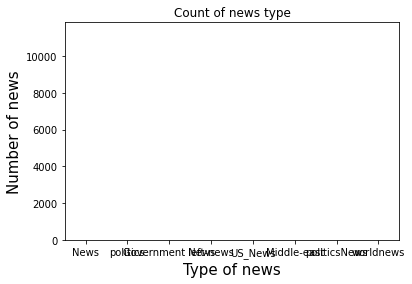

In [16]:
#Plotting the frequency plot
ax = sns.countplot(x="subject", data=clean_news,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5)

#Setting labels and font size
ax.set(xlabel='Type of news', ylabel='Number of news',title='Count of news type')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

**Insights:**
* Our dataset has more political news than any other news followed by world news
* We have some repeated class names which expresses same meaning such as news,politics,government news etc which is similar to the alternative

## Count of news subject based on true or fake 
Lets look at the count based on the fake/true outcome.

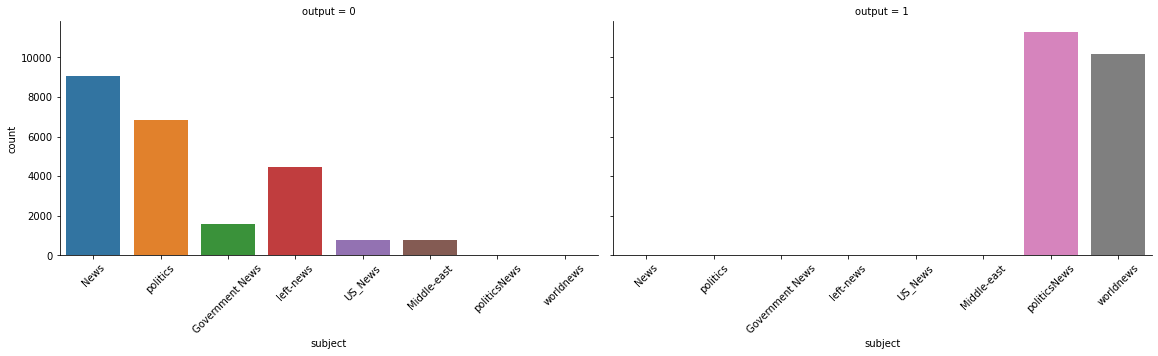

In [17]:
g = sns.catplot(x="subject", col="output",
                data=clean_news, kind="count",
                height=4, aspect=2)
g.set_xticklabels(rotation=45)

**Insights:**
* Fake news are all over the category except politics and world news 
* True news are present only in politics and world news and the count is high
* THIS IS A HIGHLY BIASED DATASET and we can expect higher accuracy which doesn't signify it is a good model considering the poor quality of dataset

## Count of fake news and true news
Let's check the count of fake and true news and confirm whether our data is balanced or not

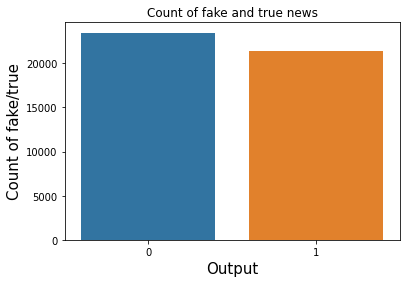

In [18]:
ax=sns.countplot(x="output", data=clean_news)
ax.set(xlabel='Output', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

## Deriving new features from the news
Lets extract more features from the news feature such as
1. Polarity: The measure which signifies the sentiment of th news
2. Review length: Length of the news(number of letters and spaces)
3. Word Count: Number of words in the news

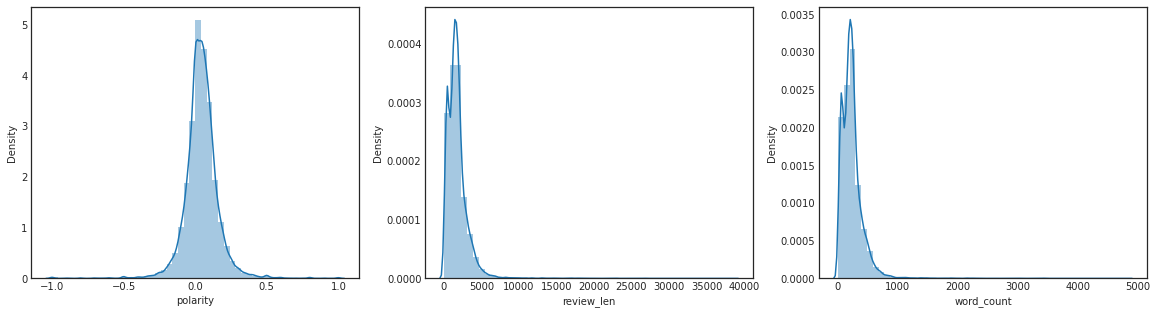

In [19]:
clean_news['polarity'] = clean_news['news'].map(lambda text: TextBlob(text).sentiment.polarity)
clean_news['review_len'] = clean_news['news'].astype(str).apply(len)
clean_news['word_count'] = clean_news['news'].apply(lambda x: len(str(x).split()))
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(clean_news['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(clean_news['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(clean_news['word_count'])
fig = plt.gcf()

**Insights:**
* Most of the polarity are neutral, neither it shows some bad news nor much happy news
* The word count is between 0-1000 and the length of the news are between 0-5000 and few near 10000 words which could be an article

## N-gram analysis

### Top 20 words in News
Let's look at the top 20 words from the news which could give us a brief idea on what news are popular in our dataset

In [20]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(clean_news['news'], 20)

for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])
df1.groupby('news').sum()['count'].sort_values(ascending=False)

trump 140400
said 130258
us 68081
would 55422
president 53189
people 41718
one 36146
state 33190
new 31799
also 31209
obama 29881
clinton 29003
house 28716
government 27392
donald 27376
reuters 27348
states 26331
republican 25287
could 24356
white 23823


news
trump         140400
said          130258
us             68081
would          55422
president      53189
people         41718
one            36146
state          33190
new            31799
also           31209
obama          29881
clinton        29003
house          28716
government     27392
donald         27376
reuters        27348
states         26331
republican     25287
could          24356
white          23823
Name: count, dtype: int64

## WordCloud of Fake and True News
Let's look at the word cloud for both fake and true news

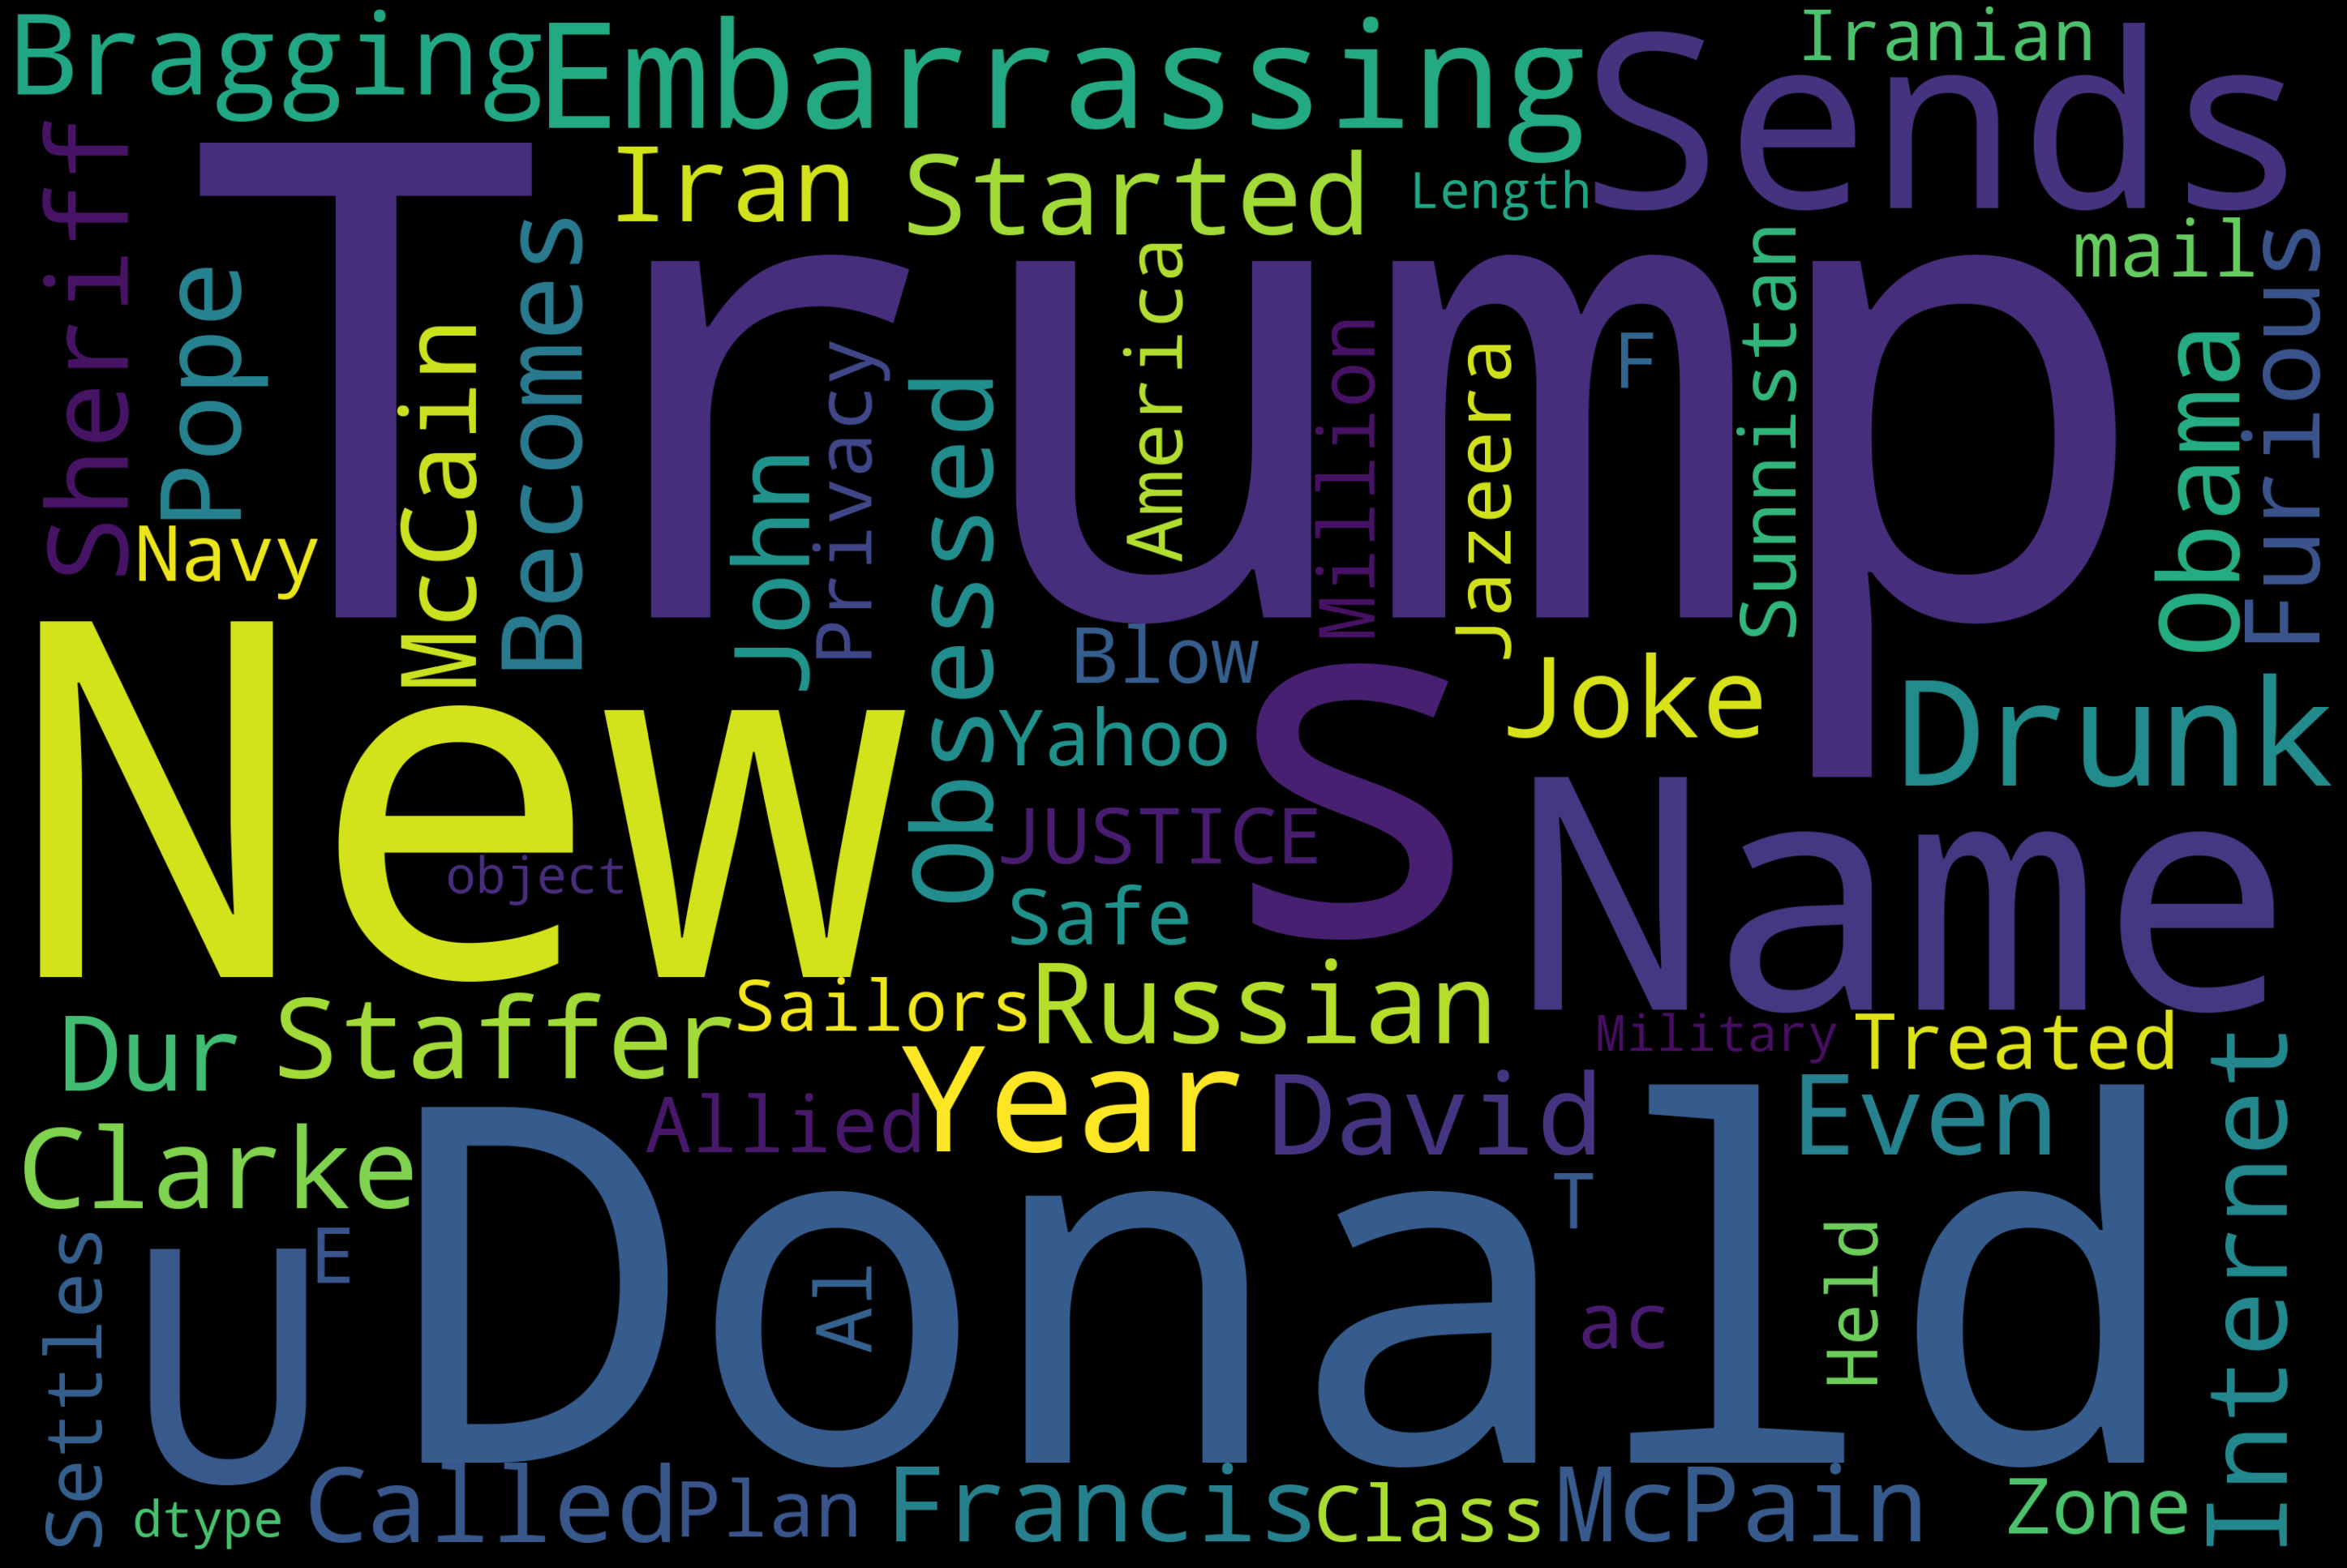

In [21]:
text = fake_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

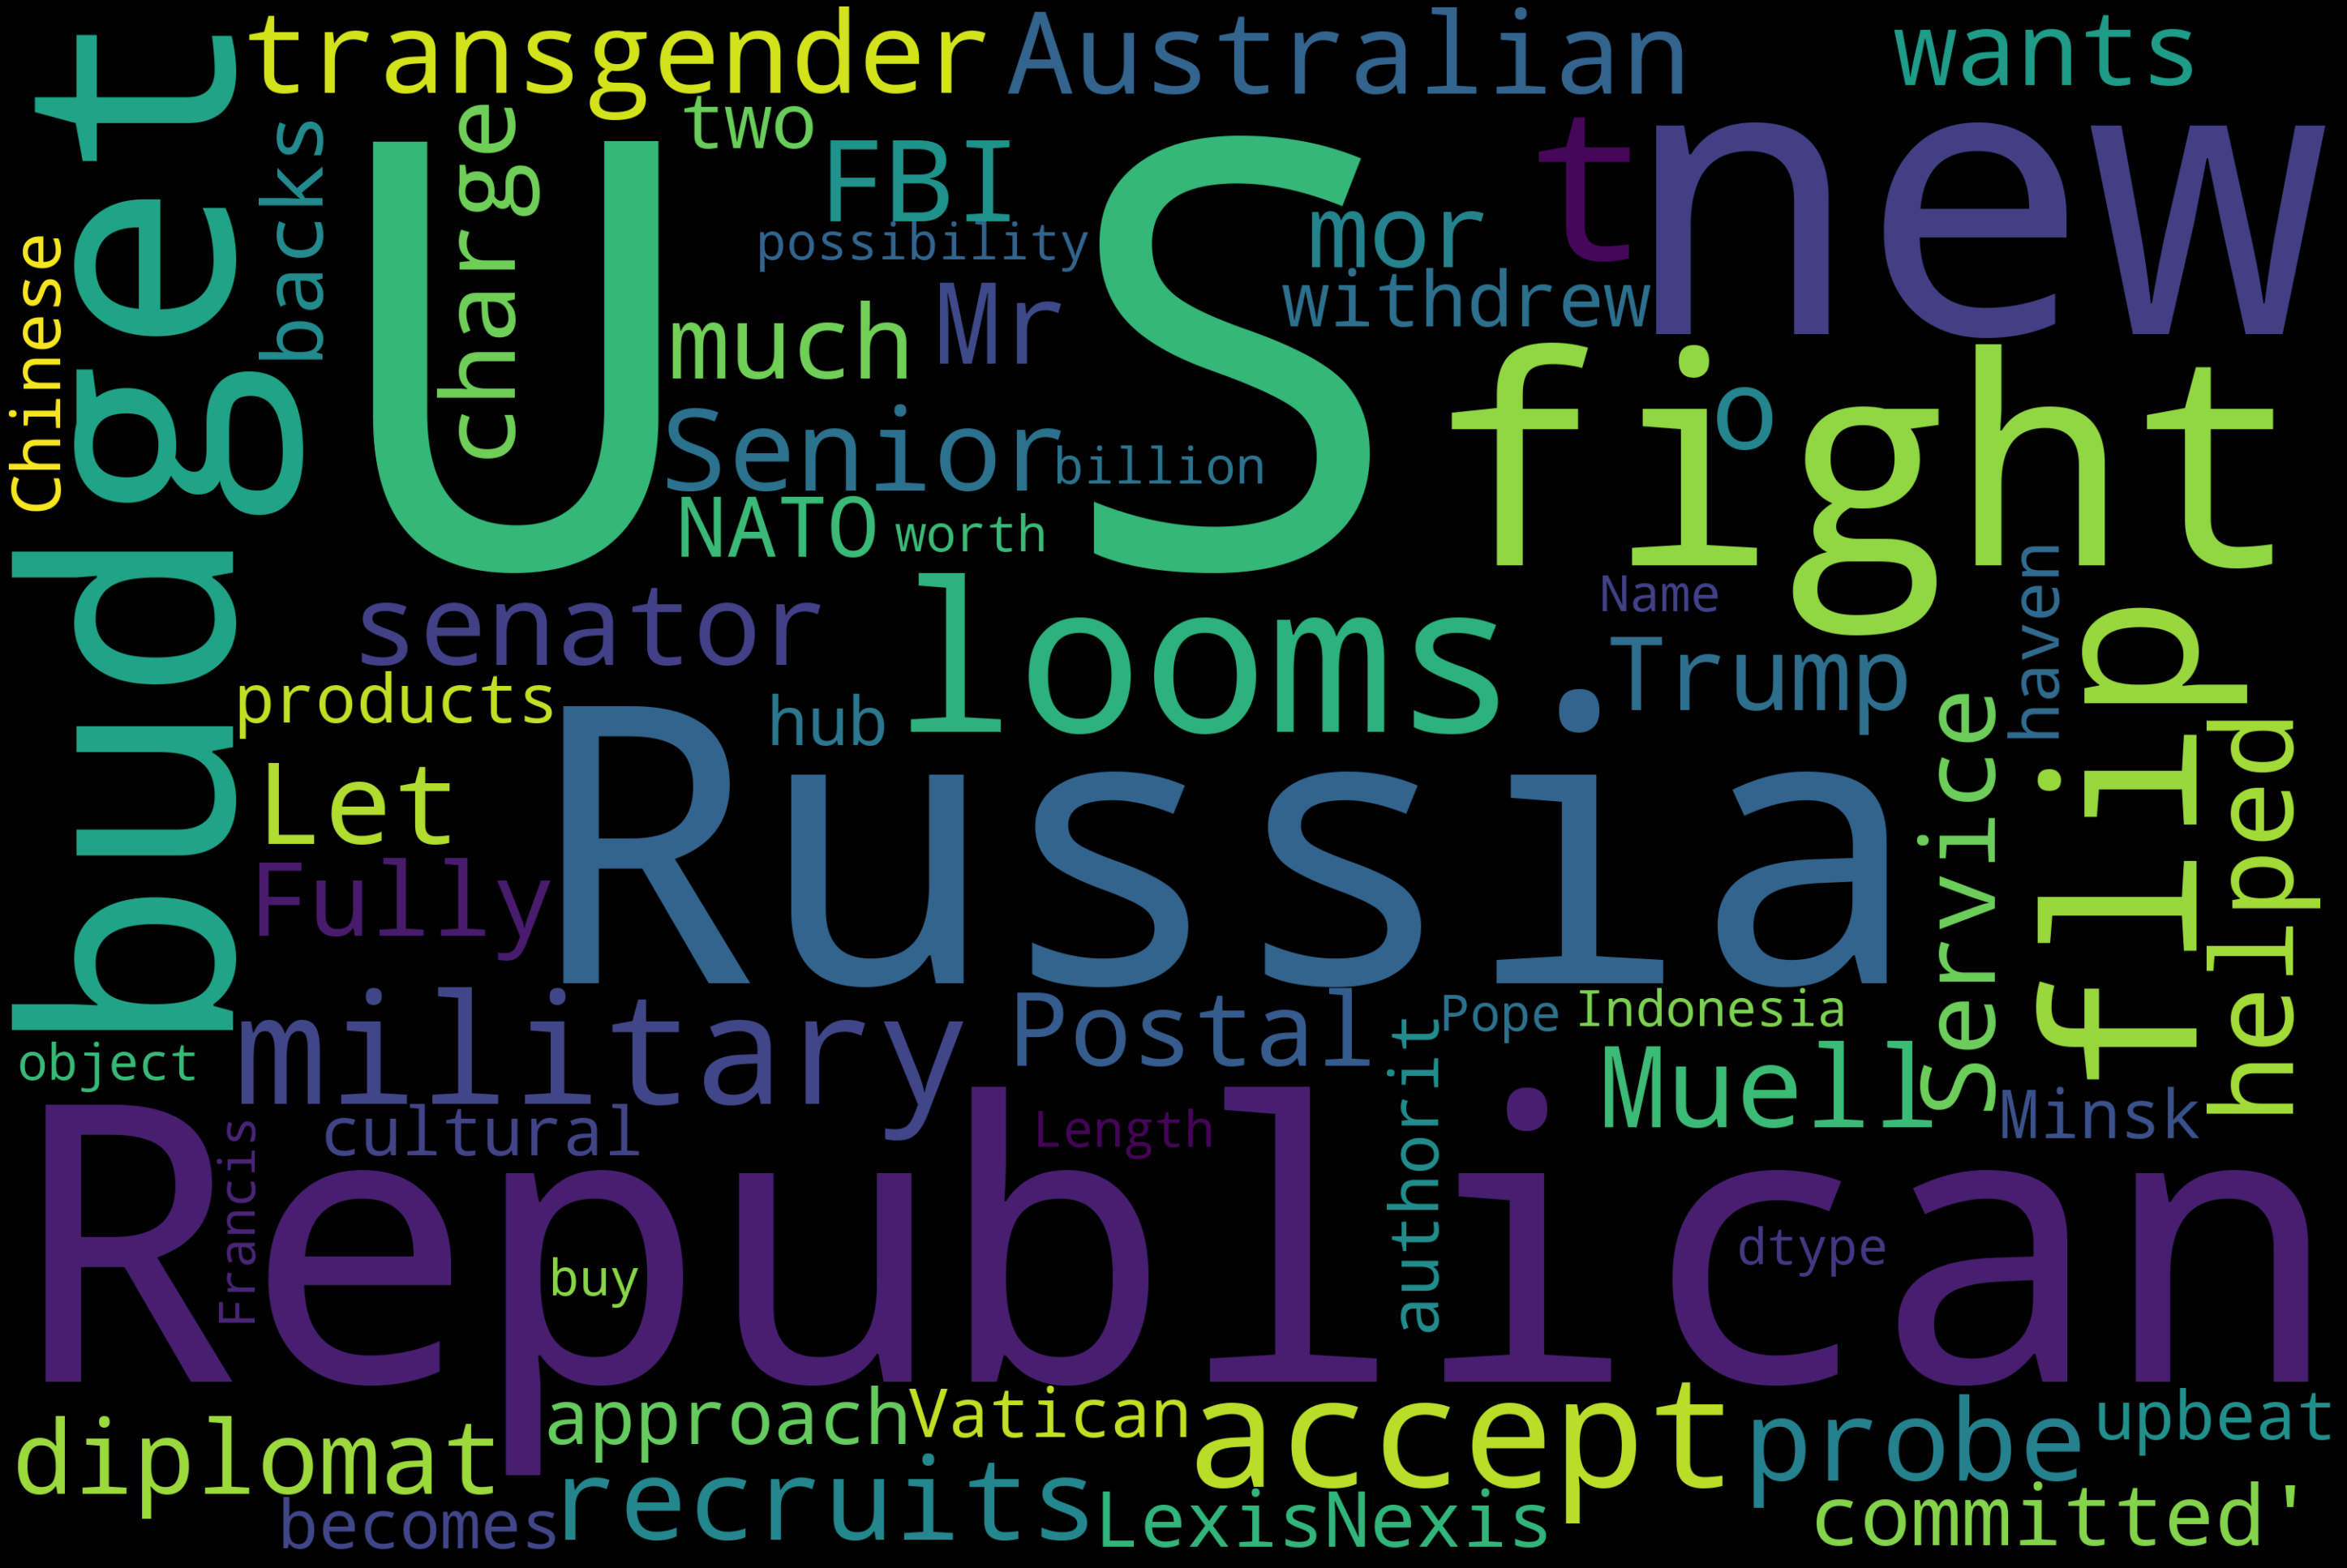

In [22]:
text = true_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


# Stemming 

In [23]:
news_features=clean_news.copy()
news_features=news_features[['news']].reset_index(drop=True)
news_features.head()

,news
0,donald trump sends embarrassing new year’s eve...
1,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes internet joke thr...
3,trump obsessed even obama’s name coded website...
4,pope francis called donald trump christmas spe...


In [24]:
stop_words = set(stopwords.words("english"))

ps = PorterStemmer()

corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)   

In [25]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like mani us christoph steeledossi prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york timesform trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clintonon top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah elsisi egypt two month elect known former aid set meet world leader trump team trump ran mere coffe boyin may papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt thendemocrat presidenti nomine hillari clinton exactli much mr papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici p

This is how a line looks like now, as computer cannot understand words and their sentiment we need to convert these words into 1's and 0's. To encode it we use TFIDF

## TFIDF

In [26]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
X= tfidf_vectorizer.fit_transform(news_features['news'])
X.shape

(44888, 5000)

In [27]:
y=clean_news['output']

### Checking for balance of data


In [28]:
print(f'Original dataset shape : {Counter(y)}')

Original dataset shape : Counter({0: 23471, 1: 21417})


Our dataset is nearly a balanced one. So let's leave balancing it.

## Train-test split(75:25)
Using train test split function we are splitting the dataset into 75:25 ratio for train and test set respectively.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

<a id="section-five"></a>
# Model Building: Fake News Classifier
As we have successfully processed the text data, not it is just a normal machine learning problem. Where from the sparse matrix we predict the classes in target feature.

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
from sklearn.linear_model import LogisticRegression
# from sklearn.cross_validation import KFold  
from sklearn.ensemble import RandomForestClassifier
# from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
nb_cv=MultinomialNB(alpha=0.1) 
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,nb_cv]
for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.9660040199274997
Decision Tree Test Accuracy: 0.9347924059961981
KNN Test Accuracy: 0.613172841991654
Naive Bayes Test Accuracy: 0.9373328405462511


From the results, we can see logistic regression outdone the rest of the algorithms followed by Naive Bayes and Decision Tree.That's great. So let's go with logistic regression with hyperparameter tuning.

### Confusion Matrix
Let's look at the true positive and true negative classified by the model

Confusion matrix, without normalization


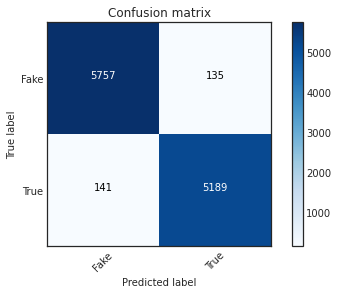

In [39]:
logreg_cv.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)
y_pred = logreg_cv.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Fake','True'])

### Classification Report


In [40]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      5892
           1       0.97      0.97      0.97      5330

    accuracy                           0.98     11222
   macro avg       0.98      0.98      0.98     11222
weighted avg       0.98      0.98      0.98     11222



All our scores are 98%. Certainly unreal to get such values. There are only changes in the support.

## ROC-AUC Curve

This is a very important curve where we decide on which threshold to setup based upon the objective criteria

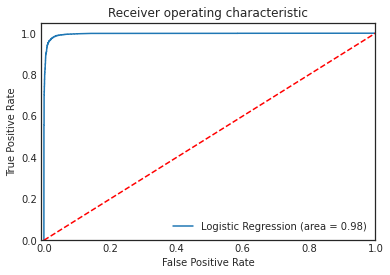

In [42]:
logit_roc_auc = roc_auc_score(y_test, logreg_cv.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg_cv.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

We should consider the AUC score here which is 98%. Very well. All metrics are performing good. The more far left the curve is better our model We can adjust our threshold based on our ROC curve to get results based on model requirements



## One hot for Embedding layers

In [43]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like mani us christoph steeledossi prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york timesform trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clintonon top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah elsisi egypt two month elect known former aid set meet world leader trump team trump ran mere coffe boyin may papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt thendemocrat presidenti nomine hillari clinton exactli much mr papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici p

In [44]:
voc_size=10000
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

## Padding embedded documents

In [45]:
sent_length=5000
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 6261 4952 7371]
 [   0    0    0 ... 7277 8017 7371]
 [   0    0    0 ... 1716 1248 7371]
 ...
 [   0    0    0 ... 9403 8760 9973]
 [   0    0    0 ... 9288 1658 8574]
 [   0    0    0 ... 8408 6772 4618]]


In [46]:
embedded_docs[1]

array([   0,    0,    0, ..., 7277, 8017, 7371], dtype=int32)

In [47]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100)) 
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5000, 40)          400000    
_________________________________________________________________
dropout (Dropout)            (None, 5000, 40)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 456,501
Trainable params: 456,501
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
len(embedded_docs),y.shape

(44888, (44888,))

## Fitting the LSTM Model
Before fitting to the model, let's consider the padded embedded object as X and y as y itself and convert them into an array.

In [49]:
X_final=np.array(embedded_docs)
y_final=np.array(y)
X_final.shape,y_final.shape

((44888, 5000), (44888,))

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
470/470 [==============================] - 141s 300ms/step - loss: 0.0131 - accuracy: 0.9959 - val_loss: 0.0701 - val_accuracy: 0.9808
Epoch 2/10
470/470 [==============================] - 140s 298ms/step - loss: 0.0062 - accuracy: 0.9982 - val_loss: 0.0840 - val_accuracy: 0.9812
Epoch 3/10
470/470 [==============================] - 139s 296ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.1441 - val_accuracy: 0.9614
Epoch 4/10
470/470 [==============================] - 140s 297ms/step - loss: 0.0067 - accuracy: 0.9981 - val_loss: 0.0999 - val_accuracy: 0.9764
Epoch 5/10
470/470 [==============================] - 139s 296ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0857 - val_accuracy: 0.9810
Epoch 6/10
470/470 [==============================] - 139s 297ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0976 - val_accuracy: 0.9783
Epoch 7/10
470/470 [==============================] - 139s 297ms/step - loss: 0.0174 - accuracy: 0.9947 - val_loss: 0.4205 -

## Evaluation of model
Now, let's predict the output for our test data and evaluate the predicted values with y_test

Confusion matrix, without normalization


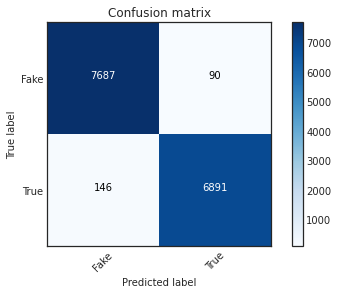

In [57]:
y_pred=model.predict_classes(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,classes=['Fake','True'])

In [58]:
accuracy_score(y_test,y_pred)

0.9840691238018091

In [59]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      7777
           1       0.99      0.98      0.98      7037

    accuracy                           0.98     14814
   macro avg       0.98      0.98      0.98     14814
weighted avg       0.98      0.98      0.98     14814



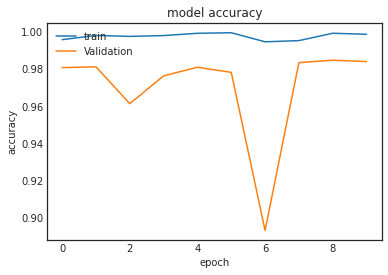

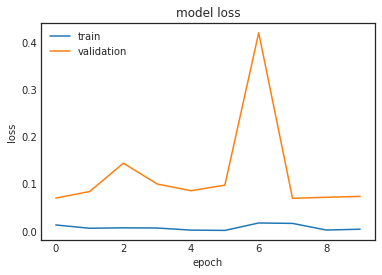

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()